In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/train/second_model_data/genuine/"

stamp


Preprocessing


In [3]:
import cv2
import numpy as np
np.random.seed(1337)  # for reproducibility
import os
import argparse

#from keras.utils.visualize_util import plot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, BatchNormalization,concatenate,GlobalMaxPool2D
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import preprocessing,Input
from tensorflow.keras import backend as K
import getpass as gp
import sys
from tensorflow.keras.models import  Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
import random
random.seed(1337)


In [4]:
print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [6]:
# def main():

train_data_dir = '/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/train/'
classes=["copies","genuine"]


forg_train=os.listdir(train_data_dir+classes[0])
org_train=os.listdir(train_data_dir+classes[1])
image_size = (128,128)

In [ ]:
print("Number of original images :", len(forg_train))
print("Number of forgery images :", len(org_train))

Number of original images : 56
Number of forgery images : 347


In [ ]:
# trainning dictionary
forg_train_dict = create_img_dict(train_data_dir,forg_train,classes[0],image_size)
org_train_dict = create_img_dict(train_data_dir,org_train,classes[1],image_size)

100%|██████████| 347/347 [11:50<00:00,  2.05s/it]


In [ ]:
# using pickle to save dict into file

import pickle

# BHS
with open('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Source code/forg_train_dict.pickle', 'wb') as handle:
    pickle.dump(forg_train_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Source code/org_train_dict.pickle', 'wb') as handle:
    pickle.dump(org_train_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load dict from file using pickle
# use this if you have saved preprocessing img into file before
import pickle
# BHS
with open('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Source code/forg_train_dict.pickle', 'rb') as handle:
    forg_train_dict = pickle.load(handle)
with open('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Source code/forg_train_dict.pickle', 'rb') as handle:
    org_train_dict = pickle.load(handle)

In [ ]:
# test img after preprocessing
from google.colab.patches import cv2_imshow 
img=forg_train_dict['stampDS-00015.png']
print("original:")
o_img = cv2.imread(train_data_dir+classes[0]+'/'+'stampDS-00015.png')
cv2_imshow(o_img)
print("preprocessing:")
cv2_imshow(img*255.)
print(img.shape)

Stamps detection

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import glob
import json
import os

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

(800, 610, 3)


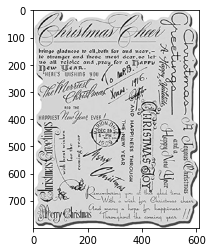

In [6]:
# image = cv2.imread(train_data_dir+classes[1]+'/'+'stampDS-00084.png') # 'sample1/1260637b.jpg' # 'sample1/1019060b.jpg' # 'process.png' # 
image = cv2.imread('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/demo.jpg') # 'sample1/1260637b.jpg' # 'sample1/1019060b.jpg' # 'process.png' # 
if max(image.shape[:2]) > 800:
    scale = 800 / max(image.shape[:2]) 
    image = cv2.resize(image, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
print(image.shape)
plt.imshow(image)
#plt.imsave('ttt.png', image)

Gray (800, 610)


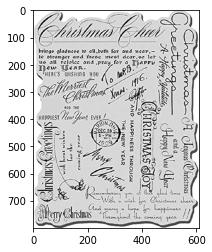

Thresh 200.0


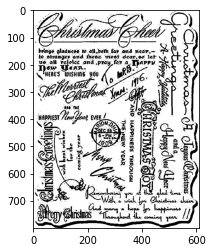

NameError: ignored

In [9]:
#grayscale
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
print('Gray', gray.shape)
plt.imshow(gray, cmap='gray')
plt.show()

blurred = cv2.GaussianBlur(gray, (7, 7), 0) 
# blurred = cv2.medianBlur(gray,5)
#split image into background and object using Otsu’s Binarization
threshold_value,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
if threshold_value < 200:
    threshold_value,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY)
print('Thresh', threshold_value)
plt.imshow(thresh, cmap='gray')
plt.show()

def make_border(imm, border = 10):
    imm[:border, :] = 0
    imm[-border:, :] = 0
    imm[:, :border:] = 0
    imm[:, -border:] = 0

ctrs = []
sel_i = 3
for i, cluster in enumerate(clusters):
    edged = cv2.Canny(cluster, 10, 250)
    make_border(edged)
    if i == sel_i:
        print('Edged',)
        plt.imshow(edged, cmap='gray')
        plt.show()
     
    kernel_size = max(image.shape) // 50
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
     
    dilation = cv2.dilate(edged, kernel, iterations=1)
    make_border(dilation)
    if i == sel_i:
        print('Dilated')
        plt.imshow(dilation, cmap='gray')
        plt.show()
    
    closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)
    make_border(closing)
    if i == sel_i:
        print('Closed')
        plt.imshow(closing, cmap='gray')
        plt.show()

    (ctrs_i, hiers) = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
    ctrs.extend(ctrs_i)
len(ctrs)

255 0


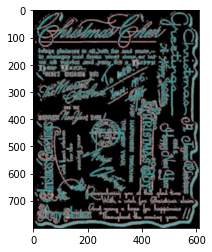

In [8]:
def blur_image(image, thresh):
    inv_thresh = np.tile((thresh == 0), reps=(3,1,1)).T.astype(np.uint8)
    inv_thresh = np.swapaxes(inv_thresh, 0, 1)
    im_copy = cv2.cvtColor(image, cv2.COLOR_RGB2LAB).astype(np.uint8) # image.copy()
    im_copy[inv_thresh == 0] = 0
    blurred_image = cv2.GaussianBlur(im_copy, (7, 7), 0, 0)         
    blurred_mask = cv2.GaussianBlur(inv_thresh, (7, 7), 0, 0)
    # blurred_image = cv2.medianBlur(im_copy,7)   
    # blurred_mask = cv2.medianBlur(inv_thresh,7)  
    result = blurred_image / (blurred_mask + 1) 
    result = (result / result.max() * 255).astype(np.uint8)
    return result
result = blur_image(image, thresh)
print(result.max(), result.min())
plt.imshow(result)

In [ ]:
def cluster_image(image, thresh, n_clusters=7):
    pixel_colors = image[thresh == 0, ...] / 255
    pixel_locs = (np.argwhere(thresh == 0) / thresh.shape[:2]) - 0.5
    pixels = np.hstack((pixel_colors, pixel_locs / 200)) # color is 2 times more important than location
    pixels = pixels.reshape(-1, pixels.shape[-1])
    # clt =  KMeans(n_clusters = n_clusters, n_jobs=-1) 
    clt =  AgglomerativeClustering(n_clusters=n_clusters) 
    # clt =  DBSCAN(n_jobs=-1) 
    clt.fit(pixels)
    result = []
    for lab in np.unique(clt.labels_):
        clust = np.ones(shape=image.shape[:2]) * 255
        clust[thresh == 0] = (clt.labels_ != lab) * 255
        result.append(clust.astype(np.uint8))
    return result
# clusters = cluster_image(cv2.cvtColor(image, cv2.COLOR_RGB2LAB), thresh, n_clusters=7)
clusters = cluster_image(result , thresh, n_clusters=7)
print(len(clusters))
for c in clusters:
    print((c==0).sum())
    plt.imshow(c, cmap='gray')
    plt.show()

In [ ]:
def make_border(imm, border = 10):
    imm[:border, :] = 0
    imm[-border:, :] = 0
    imm[:, :border:] = 0
    imm[:, -border:] = 0
    
def get_contours(image):
    #grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY).astype('uint8')
    
    #split image into background and object using Otsu’s Binarization
    threshold_value,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    threshold_value,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if threshold_value < 100:
        threshold_value,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY) 
    
    #blur masked image
    blurred = blur_image(image, thresh)
    
    #cluster image by color and location
    clusters = cluster_image(blurred, thresh, n_clusters=7)
    ctrs = []
    for cluster in clusters:
        # detect edges
        edged = cv2.Canny(cluster, 10, 250)
        make_border(edged)
         
        # dilate = make objects thicker
        kernel_size = max(image.shape) // 50
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        dilation = cv2.dilate(edged, kernel, iterations=1)
        make_border(dilation)
        
        # close objects
        closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)
        make_border(closing)
         
        (ctrs_clust, hiers) = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        ctrs.append(ctrs_clust)
    return ctrs
ctrs = get_contours(image)
print(len(ctrs), sum(len(l) for l in ctrs))

In [ ]:
def is_1_inside_2(ctr1, ctr2, gap=5):
    x1, y1, w1, h1 = cv2.boundingRect(ctr1)
    x2, y2, w2, h2 = cv2.boundingRect(ctr2)
    inside_x = (x1 + gap >= x2) and (x1 + w1 <= x2 + w2 + gap)
    inside_y = (y1 + gap >= y2) and (y1 + h1 <= y2 + h2 + gap)  
    return inside_x and inside_y

def get_square(ctr):
    h, w = cv2.boundingRect(ctr)[2:4]
    return h * w

def filter_contours_by_square(contours, image, min_pct=0.0005, max_pct=0.9):
    image_square = image.shape[0] * image.shape[1] 
    min_square = image_square * min_pct
    max_square = image_square * max_pct
    return [[ctr for ctr in ctrs_list if  max_square >= get_square(ctr) >= min_square] 
            for ctrs_list in contours]

def get_top_contours(contours):
    result = []
    for ctrs_list in contours:
        top_ctrs = []
        for ctr in sorted(ctrs_list, key=get_square, reverse=True):  # from largest to smallest
            is_inside_top = False
            for top_ctr in top_ctrs:
                if is_1_inside_2(ctr, top_ctr):
                    is_inside_top = True
                    break
            if not is_inside_top:
                top_ctrs.append(ctr)
        result.extend(top_ctrs)
    return result

def filter_by_inclusion(contours):
    top_ctrs = []
    for ctr in sorted(contours, key=get_square, reverse=True):  # from largest to smallest
        wrong_inclusion = False
        for top_ctr in top_ctrs:
            if (is_1_inside_2(ctr, top_ctr) 
                and ((get_square(ctr) < 0.5 * get_square(top_ctr))
                     or (0.06 * get_square(top_ctr) < get_square(ctr)))):
                wrong_inclusion = True
                break
        if not wrong_inclusion:
            top_ctrs.append(ctr)
    return top_ctrs

filtered_ctrs = filter_contours_by_square(ctrs, image, min_pct=0.001, max_pct=0.9)
print(len(filtered_ctrs))

top_ctrs = get_top_contours(filtered_ctrs)
print(len(top_ctrs))

top_ctrs = filter_by_inclusion(top_ctrs)
print(len(top_ctrs))

7
71
9


In [ ]:
def plot_ctrs(image, name, contours, **args):
    result = image.copy()
    for i, ctr in enumerate(top_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        roi = result[round(1/scale * y) : round(1/scale * (y+h)), round(1/scale * x) : round(1/scale * (x+w))]
        new_image = cv2.imwrite('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/copies_crop/'+name+'-crop-'+str(i)+".png", roi)
        # cv2.rectangle(result,(round(1/scale*x),round(1/scale*y)),( round(1/scale*(x + w)), round(1/scale*(y + h))), **args)
    return result

# result = plot_ctrs(image, name, filtered_ctrs, color=(0,255,0), thickness=5)
# plt.imshow(result)
# plt.imsave('result_cluster_blur2.png', result)

In [ ]:
def filter_by_inclusion(contours):
    top_ctrs = []
    for ctr in sorted(contours, key=get_square, reverse=True):  # from largest to smallest
        wrong_inclusion = False
        for top_ctr in top_ctrs:
            if (is_1_inside_2(ctr, top_ctr) 
                and ((get_square(ctr) < 0.5 * get_square(top_ctr))
                     or (0.06 * get_square(top_ctr) < get_square(ctr)))):
                wrong_inclusion = True
                break
        if not wrong_inclusion:
            top_ctrs.append(ctr)
    return top_ctrs
for index,name in enumerate(forg_train):
  # if index == 3:
    print(name)
    x = name.split(".")
    image = cv2.imread(train_data_dir+classes[0]+'/'+name)  
    if max(image.shape[:2]) > 800:
        scale = 800 / max(image.shape[:2]) 
        image = cv2.resize(image, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
    
    #grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    
    #split image into background and object using Otsu’s Binarization
    threshold_value,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if threshold_value < 200:
        threshold_value,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY)

    ctrs = []
    sel_i = 3
    for i, cluster in enumerate(clusters):
        edged = cv2.Canny(cluster, 10, 250)
        make_border(edged)
        
        kernel_size = max(image.shape) // 50
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        
        dilation = cv2.dilate(edged, kernel, iterations=1)
        make_border(dilation)
        
        closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)
        make_border(closing)

        (ctrs_i, hiers) = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
        ctrs.extend(ctrs_i)
    len(ctrs)
    result = blur_image(image, thresh)
    clusters = cluster_image(result , thresh, n_clusters=7)
    print(len(clusters))
    ctrs = get_contours(image)
    filtered_ctrs = filter_contours_by_square(ctrs, image, min_pct=0.005, max_pct=0.9)
    top_ctrs = get_top_contours(filtered_ctrs)
    top_ctrs = filter_by_inclusion(top_ctrs)
    image = cv2.imread(train_data_dir+classes[0]+'/'+name) 
    plot_ctrs(image, x[0], filtered_ctrs, color=(0,255,0), thickness=5)
    # result = plot_ctrs(image, name, filtered_ctrs, color=(0,255,0), thickness=5)
    # plt.imshow(result)

stampDS-00001.png
7
stampDS-00002.png
7
stampDS-00003.png
7
stampDS-00004.png
7
stampDS-00005.png
7
stampDS-00006.png
7
stampDS-00007.png
7
stampDS-00008.png
7
stampDS-00009.png
7
stampDS-00010.png
7
stampDS-00011.png
7
stampDS-00012.png
7
stampDS-00013.png
7
stampDS-00014.png
7


Check for saving img 

In [ ]:
train_data_dir = '/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/'
classes=["copies","genuine"]


forg_train=os.listdir(train_data_dir+classes[0])
org_train=os.listdir(train_data_dir+classes[1])
image_size = (128,128)
print("Number of forgery images :", len(forg_train))
print("Number of original images :", len(org_train))

Number of forgery images : 14
Number of original images : 80


Image Classification Using SVM: Step 1

In [ ]:
import os
import re

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np
import cv2
from PIL import Image
from skimage.io import imread
from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
from skimage.transform import resize

from pathlib import Path
import matplotlib.pyplot as plt

Data Preprocessing

In [ ]:
def get_image(dimension=(64, 64)):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    stamp_train = []
    no_train = []
    regexp = re.compile(r'real')
    regeximg = re.compile(r'stampDS')
    # regeximgdel = re.compile(r'stampstampDS')
    data_dir = '/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/genuine_crop/'
    i=0
    for file in os.listdir(data_dir):
      # if regeximgdel.search(file):
        if regeximg.search(file):
            # print(file)
            img = cv2.imread(data_dir+file)
            # img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            if regexp.search(file):
                # stamp_train.append(img_resized) 
                cv2.imwrite('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/genuine_crop/stamp/' + file, img)
            else:
                # no_train.append(img_resized)
                cv2.imwrite('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/genuine_crop/no_stamp/' + file, img)
            # os.remove('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/genuine_crop/' + file)
    return stamp_train, no_train  

# stamp_train,no_train = get_image()

In [ ]:
def get_image(dimension=(64, 64)):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    stamp_train = []
    no_train = []
    regexp = re.compile(r'real')
    regeximg = re.compile(r'stampDS')
    data_dir = '/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/copies_crop/'
    for file in os.listdir(data_dir):
        if regeximg.search(file):
            print(file)
            img = cv2.imread(data_dir+file)
            # img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            if regexp.search(file):
                cv2.imwrite('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/copies_crop/stamp/' + file, img)
                # stamp_train.append(img_resized) 
            else:
                cv2.imwrite('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/copies_crop/no_stamp/' + file, img)
                # no_train.append(img_resized)
            os.remove('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/copies_crop/' + file)
    return stamp_train, no_train  

# test_stamp_train,test_no_train = get_image()

stampDS-00001-crop-0.png
stampDS-00001-crop-3.png
stampDS-00001-crop-4.png
stampDS-00001-crop-5.png
stampDS-00001-crop-6.png
stampDS-00001-crop-7.png
stampDS-00001-crop-8.png
stampDS-00002-crop-0.png
stampDS-00002-crop-3.png
stampDS-00002-crop-4.png
stampDS-00002-crop-5.png
stampDS-00002-crop-6.png
stampDS-00002-crop-7.png
stampDS-00003-crop-0.png
stampDS-00003-crop-3.png
stampDS-00003-crop-4.png
stampDS-00003-crop-5.png
stampDS-00003-crop-6.png
stampDS-00003-crop-7.png
stampDS-00003-crop-8.png
stampDS-00004-crop-0.png
stampDS-00004-crop-2.png
stampDS-00004-crop-4.png
stampDS-00004-crop-5.png
stampDS-00004-crop-6.png
stampDS-00004-crop-7.png
stampDS-00005-crop-0.png
stampDS-00006-crop-0.png
stampDS-00006-crop-3.png
stampDS-00006-crop-4.png
stampDS-00006-crop-5.png
stampDS-00006-crop-6.png
stampDS-00007-crop-0.png
stampDS-00008-crop-0.png
stampDS-00008-crop-1.png
stampDS-00008-crop-2.png
stampDS-00008-crop-3.png
stampDS-00008-crop-4.png
stampDS-00008-crop-5.png
stampDS-00008-crop-6.png


Build model

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = "/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/train/genuine_crop/"
test_df = "/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/genuine_crop/" 
os.listdir(train_dir)

['stamp', 'no_stamp']

In [ ]:
train_datagen = ImageDataGenerator(rescale=(1/255.),shear_range = 0.2,zoom_range=0.2,
                                   horizontal_flip=True)
training_set = train_datagen.flow_from_directory(directory = train_dir,target_size=(64,64),
                                                batch_size=32,
                                                class_mode = "binary")
test_datagen = ImageDataGenerator(rescale=(1/255.))
test_set = test_datagen.flow_from_directory(directory = test_df,target_size=(64,64),
                                                batch_size=32,
                                                class_mode = "binary")

Found 2308 images belonging to 2 classes.
Found 544 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten
from tensorflow.keras.regularizers import l2

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))

#Output layer
model.add(Dense(1,kernel_regularizer=l2(0.01),activation = "linear"))

In [ ]:
model.compile(optimizer = 'adam', loss = "hinge", metrics = ['accuracy'])
history = model.fit(x = training_set,validation_data = test_set,epochs=15)

Epoch 1/15
73/73 [==============================] - 669s 9s/step - loss: 0.4134 - accuracy: 0.8163 - val_loss: 0.3743 - val_accuracy: 0.8143
Epoch 2/15
73/73 [==============================] - 56s 768ms/step - loss: 0.3639 - accuracy: 0.8163 - val_loss: 0.3378 - val_accuracy: 0.8143
Epoch 3/15
73/73 [==============================] - 55s 756ms/step - loss: 0.3153 - accuracy: 0.8180 - val_loss: 0.2935 - val_accuracy: 0.8382
Epoch 4/15
73/73 [==============================] - 55s 763ms/step - loss: 0.2642 - accuracy: 0.8782 - val_loss: 0.2316 - val_accuracy: 0.9007
Epoch 5/15
73/73 [==============================] - 56s 766ms/step - loss: 0.2098 - accuracy: 0.9081 - val_loss: 0.1642 - val_accuracy: 0.9467
Epoch 6/15
73/73 [==============================] - 56s 765ms/step - loss: 0.1907 - accuracy: 0.9177 - val_loss: 0.2110 - val_accuracy: 0.9265
Epoch 7/15
73/73 [==============================] - 55s 757ms/step - loss: 0.1679 - accuracy: 0.9307 - val_loss: 0.2065 - val_accuracy: 0.9357
E

In [ ]:
# save the model to disk
filename = '/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Model/classification_1_model.h5'
from keras.models import load_model

model.save('/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Model/classification_1_model.h5')

Image Classification Using SVM: Step 2

In [ ]:
import random
from sklearn import svm
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from skimage import io, filters
from skimage.transform import resize
from skimage.feature import hog, ORB, CENSURE, corner_peaks, corner_harris, BRIEF
import joblib
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classes = ["copies","genuine"]

def main():
    DataSet = []
    LabelSet = []
    lengthV = []
    trainPaths = ['/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/train/second_model_data/'+c+ '/stamp/' for c in classes ]
    testPaths =  ['/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/second_model_data/'+c+'/stamp/'   for c in classes ]
    
    resList = []
    boolList = []
    pos = 0
    ind = 0
    #if you wish to automatically perform both feature selection optimzation and svm optimization at the same time
    #comment out next line and comment in section above
    #Warning: Very long runtime for algorithm because of grid search
    useList = [True, True, True, True]
    #print(useList)
    
    for c in range(len(classes)):
        #get label for features to be added
        className = classes[c]
        #get file path for folder with images
        path = trainPaths[c]
        #initialize feature detectors/extractors
        #Censure extractor
        detector = CENSURE()
        #ORB extractor
        detector2 = ORB(n_keypoints=50)
        #get all file names from the folder
        files = os.listdir(path)
        nfiles = len(files)
        #repeat for each file
        for i in range(nfiles):
            #initialize feature vector as empty list
            featureVector = []
            infile = files[i]
            #read image as grayscale numpy.ndarray
            img = io.imread(path+infile, as_gray=True)
            #get histogram for grayscale value intensity
            hist = np.histogram(img, bins=256)
            #resize image
            img = resize(img, (400,400))
            #extract features but do not yet add them to feature vector
            detector2.detect_and_extract(img)
            #extract HOG features, add them to featurevector
            a = fd = hog(img, orientations=9, pixels_per_cell=(32, 32),
                    cells_per_block=(1,1), visualize=False)
            #add histogramm to featurevector
            for h in hist:
                fd = np.append(fd, h)
            #if corresponding boolean in uselist is true add features to featureVector --> Feature selection happens here
            if(useList[0]):                            
                detector.detect(img)
                fd = np.append(fd, [np.array(detector.keypoints).flatten()])
            if(useList[1]):
                fd = np.append(fd, detector2.keypoints)
            if(useList[2]):
                fd = np.append(fd, edgeExtract(img, 100))
            if(useList[3]):
                corners =  corner_peaks(corner_harris(img),min_distance=1)
                fd = np.append(fd, corners)
            #get length of featurevector for later operations
            lengthV.append(len(fd))
            #add featureVector list to dataset that is fed into svm
            DataSet.append(fd)
            #get label name
            ind = classes.index(className)
            #add label to label dataset that is fed into svm
            LabelSet.append(ind)
    #get length of biggest sized featurevector
    max = np.amax(lengthV)
    lengthV = []
    DataSet2 = []
    #pad dataset with zeroes so that all featurevectors have the same length --> important for svm
    for d in DataSet:
        d = np.pad(d, (0, max - len(d)), 'constant')
        DataSet2.append(d)
        lengthV.append(len(d))
    DataSet = DataSet2
    #perform a grid search with maximum number of possible threads (usually 4)
    if __name__=='__main__':
        gridSearch(DataSet, LabelSet)
    # Get classifiers
    classifiers = [
        ('Logistic Regression (C=1)', LogisticRegression(C=1)),
        ('Logistic Regression (C=1000)', LogisticRegression(C=10000)),
        # ('RBM 200, n_iter=40, LR=0.01, Reg: C=1',
        #  Pipeline(steps=[('rbm', BernoulliRBM(n_components=200,
        #                                       n_iter=40,
        #                                       learning_rate=0.01,
        #                                       verbose=True)),
        #                  ('logistic', LogisticRegression(C=1))])),
        # ('RBM 200, n_iter=40, LR=0.01, Reg: C=10000',
        #  Pipeline(steps=[('rbm', BernoulliRBM(n_components=200,
        #                                       n_iter=40,
        #                                       learning_rate=0.01,
        #                                       verbose=True)),
        #                  ('logistic', LogisticRegression(C=10000))])),
        # ('RBM 100', Pipeline(steps=[('rbm', BernoulliRBM(n_components=100)),
        #                             ('logistic', LogisticRegression(C=1))])),
        # ('RBM 100, n_iter=20',
        #  Pipeline(steps=[('rbm', BernoulliRBM(n_components=100, n_iter=20)),
        #                  ('logistic', LogisticRegression(C=1))])),
        # ('RBM 256', Pipeline(steps=[('rbm', BernoulliRBM(n_components=256)),
        #                             ('logistic', LogisticRegression(C=1))])),
        # ('RBM 512, n_iter=100',
        #  Pipeline(steps=[('rbm', BernoulliRBM(n_components=512, n_iter=10)),
        #                  ('logistic', LogisticRegression(C=1))])),
        # ('NN 500:200 dropout',
        #  skflow.TensorFlowEstimator(model_fn=dropout_model,
        #                             n_classes=10,
        #                             steps=20000)),
        # ('CNN', skflow.TensorFlowEstimator(model_fn=conv_model,
        #                                    n_classes=10,
        #                                    batch_size=100,
        #                                    steps=20000,
        #                                    learning_rate=0.001)),
        ('SVM, adj.', SVC(probability=True,
                          kernel="rbf",
                          C=2.8,
                          gamma=.0073,
                          cache_size=200)),
        ('SVM, linear', SVC(kernel="linear", C=0.025, cache_size=200,probability=True)),
        ('SVC, rbf', SVC(kernel='rbf', C=10.0, gamma=1.0000000000000001e-09, probability=True)),
        ('k nn', KNeighborsClassifier(3)),
        ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
        ('Random Forest', RandomForestClassifier(n_estimators=50, n_jobs=10)),
        ('Random Forest 2', RandomForestClassifier(max_depth=5,
                                                   n_estimators=10,
                                                   max_features=1,
                                                   n_jobs=10)),
        ('AdaBoost', AdaBoostClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Gradient Boosting', GradientBoostingClassifier()),
        ('LDA', LinearDiscriminantAnalysis()),
        ('QDA', QuadraticDiscriminantAnalysis())
    ]

    # Fit them all
    classifier_data = {}
    for clf_name, clf in classifiers:
        clf.fit(DataSet, LabelSet)
        joblib.dump(clf, '/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Model/classification_2_model'+clf_name+'.pk1')
        scores = cross_val_score(clf, DataSet, LabelSet, cv=10)
        print(scores)
        print("Accuracy of %s : %0.2f (+/- %0.2f)" % (clf_name,scores.mean(), scores.std() * 2))

    # #train and examine svm with default values for comparison later
    # clf = svm.SVC(kernel='rbf', C=10.0, gamma=1.0000000000000001e-09)
    # clf.fit(DataSet, LabelSet)
    # joblib.dump(clf, '/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Model/classification_2_model'+'.pk1')
    # scores = cross_val_score(clf, DataSet, LabelSet, cv=10)
    # #print results of default svm
    # print(scores)
    # print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
#extract edge histogramm, bins number = 100    
def edgeExtract(img, bins):
    retVal = []
    #apply vertical and horizontal sobel filters to get two histogramms, once of vertical and once of horizontal edges
    #vertical
    fs = filters.sobel_v(img)
    #horizontal
    angs = filters.sobel_h(img)
    #compute histograms
    lhist = np.histogram(fs,bins,normed=True,range=(0,1))
    ahist = np.histogram(angs, bins,normed=True,range=(-180,180))
    #fuse histograms into one list
    retVal.extend(lhist[0].tolist())
    retVal.extend(ahist[0].tolist())
    return retVal

In [ ]:
#Perform grid search, 
# if optimum feature selection list is to be found verbalize = false
def gridSearch(DataSet, LabelSet, verbalize = True):
    #define logspace/interval from which c and gamma valuest are computed and saved to a dictionary to be passed as a parameter
    #c from 1e-2 to 1e10
    C_range = np.logspace(-2, 10, 13)
    #gamma from 1e-9 to 1e3
    gamma_range = np.logspace(-9, 3, 13)
    param_grid = dict(gamma=gamma_range, C=C_range)
    #grid input parameter
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    #perform grid search with multiple threads for added performance
    if(verbalize):
        grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, n_jobs=-1)
    #perform grid search with one thread and return value --> multiple threads do not work with return values
    else:
        grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, n_jobs=1)
    #find optimal values
    grid.fit(DataSet, LabelSet)
    #print results of test for optimal values
    if(verbalize):
        print("The best parameters are %s with a score of %0.2f" 
            % (grid.best_params_, grid.best_score_))
    else:
        #return best scores for different feature selections
        return grid.best_score_

In [ ]:
#same as main function, however a sample of 100 images is drawn for each image
def selectFeatures(useList):
    DataSet = []
    LabelSet = []
    lengthV = []
    trainPaths = ['/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/train/second_model_data/'+c+ '/stamp/' for c in classes ]
    testPaths =  ['/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/second_model_data/'+c+'/stamp/'   for c in classes ]
    for c in range(len(classes)):
        className = classes[c]
        path = trainPaths[c]
        detector = CENSURE()
        detector2 = ORB(n_keypoints=50)
        detector3 = BRIEF(patch_size=49)
        files = os.listdir(path)
        #sample
        files = random.sample(files, 100)
        nfiles = len(files)
        for i in range(nfiles):
            featureVector = []
            infile = files[i]
            img = io.imread(path+infile, as_gray=True)
            hist = np.histogram(img, bins=256)
            img = resize(img, (400,400))
            detector2.detect_and_extract(img)
            detector.detect(img)
            a = fd = hog(img, orientations=9, pixels_per_cell=(32, 32),
                    cells_per_block=(1,1), visualize=False)
            for h in hist:
                fd = np.append(fd, h)
            if(useList[0]):
                fd = np.append(fd, [np.array(detector.keypoints).flatten()])
            if(useList[1]):
                fd = np.append(fd, detector2.keypoints)
            if(useList[2]):
                fd = np.append(fd, edgeExtract(img, 100))
            l1 = len(fd)
            corners =  corner_peaks(corner_harris(img),min_distance=1)
            if(useList[3]):
                fd = np.append(fd, corners)
            lengthV.append(len(fd))  
            DataSet.append(fd)
            ind = classes.index(className)
            LabelSet.append(ind)
    max = np.amax(lengthV)
    lengthV = []
    DataSet2 = []
    for d in DataSet:
        d = np.pad(d, (0, max - len(d)), 'constant')
        DataSet2.append(d)
        lengthV.append(len(d))
    DataSet = DataSet2
    res = 0
    #perform gridsearch with one thread
    if __name__=='__main__':
        res = gridSearch(DataSet, LabelSet, False)
        return res

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
main()

The best parameters are {'C': 10.0, 'gamma': 1e-09} with a score of 0.95
[0.94230769 0.96153846 0.96153846 0.94230769 0.98076923 1.
 0.96078431 0.92156863 0.66666667 1.        ]
Accuracy of Logistic Regression (C=1) : 0.93 (+/- 0.18)
[0.94230769 0.92307692 0.96153846 0.94230769 0.98076923 1.
 0.94117647 0.96078431 0.74509804 1.        ]
Accuracy of Logistic Regression (C=1000) : 0.94 (+/- 0.14)
[0.80769231 0.80769231 0.82692308 0.82692308 0.82692308 0.82692308
 0.82352941 0.82352941 0.82352941 0.82352941]
Accuracy of SVM, adj. : 0.82 (+/- 0.01)
[0.94230769 0.96153846 0.96153846 0.98076923 0.98076923 1.
 0.96078431 0.92156863 0.68627451 1.        ]
Accuracy of SVM, linear : 0.94 (+/- 0.18)
[0.98076923 0.98076923 0.98076923 0.98076923 0.96153846 0.94230769
 0.98039216 0.92156863 0.76470588 0.96078431]
Accuracy of SVC, rbf : 0.95 (+/- 0.13)
[0.98076923 0.92307692 0.96153846 0.96153846 0.96153846 1.
 1.         0.84313725 0.35294118 0.98039216]
Accuracy of k nn : 0.90 (+/- 0.37)
[0.8846153

*Evaluate*  model

Model 1

In [ ]:
model = load_model("/content/drive/MyDrive/Đồ án tốt nghiệp - Nghĩa, Duy/Model/Date 29-10/classification_1_model.h5")

In [ ]:
test_df = "/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/genuine_crop/" 
test_datagen = ImageDataGenerator(rescale=(1/255.))
test_set = test_datagen.flow_from_directory(directory = test_df,target_size=(64,64),
                                                batch_size=32,
                                                class_mode = "binary")

Found 544 images belonging to 2 classes.


In [ ]:
results = model.evaluate(test_set, batch_size=128) 
print("test loss, test acc:", results)

17/17 [==============================] - 10s 564ms/step - loss: 0.2731 - accuracy: 0.9191
test loss, test acc: [0.2731156647205353, 0.9191176295280457]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model.metrics_names

['loss', 'accuracy']

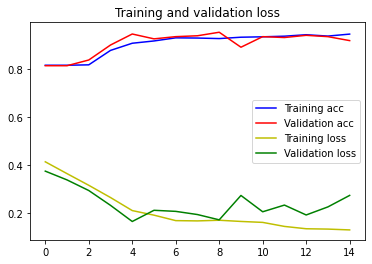

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()
 
plt.figure()

In [ ]:
test_data_dir = '/content/drive/My Drive/Đồ án tốt nghiệp - Nghĩa, Duy/Dataset/Starver_split_8_2/test/genuine_crop/'
classes=["stamp","no_stamp"]


class_s_test=os.listdir(test_data_dir+classes[0])
class_ns_test=os.listdir(test_data_dir+classes[1])
img_size = (128 , 128)

# create test data
x_test=[]
y_test=[]

for name in class_s_test:
  stamp_img = cv2.imread(test_data_dir+"/"+classes[0]+"/"+name)
  img = cv2.resize(stamp_img,(64,64))
  img = np.reshape(img,[64,64,3])
  x_test.append(img)
  y_test.append(0.)

for name in class_ns_test:
  not_stamp_img = cv2.imread(test_data_dir+"/"+classes[1]+"/"+name)
  img = cv2.resize(not_stamp_img,(64,64))
  img = np.reshape(img,[64,64,3])
  x_test.append(img)
  y_test.append(1.)

x_test = np.array(x_test)
print(len(x_test))
y_test = np.array(y_test)
print(len(y_test))

544
544


In [ ]:
y_pred = (model.predict(x_test) < 0.5).astype('int32')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [ ]:
# threshold = 0.5 as default
cm1 = metrics.confusion_matrix(y_test, list(y_pred))
print(cm1)

[[ 61  40]
 [  8 435]]


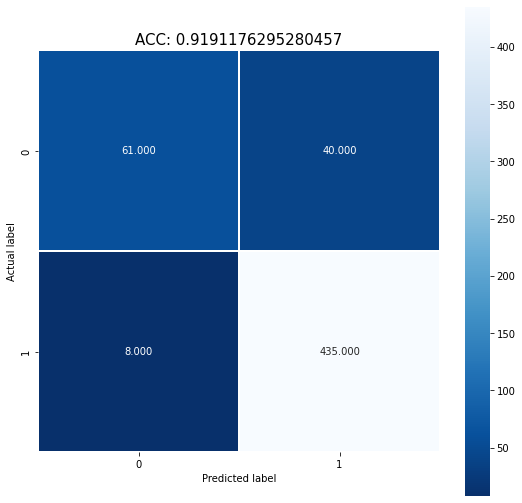

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'ACC: {0}'.format(results[1])
plt.title(all_sample_title, size = 15);

In [ ]:
# Threshold = 0.5 as default
tn, fp, fn, tp = cm1.flatten()
acc = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
f2 = 2*(5*precision*recall)/(4*precision+recall)
far = fn / (fn + tp)
frr = fp/(fp + tn)

print("FAR:", far)
print('FRR:', frr)
print("ERR::", 1-acc)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("F2-score:", f2)

FAR: 0.01805869074492099
FRR: 0.39603960396039606
ERR:: 0.08823529411764708
Accuracy: 0.9117647058823529
Precision: 0.9157894736842105
Recall: 0.981941309255079
F1-score: 0.9477124183006537
F2-score: 1.9359145527369823
